In [18]:
import json
import pandas as pd
import numpy as np
import re
import sqlite3 as sql
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
stats = open('chaps-Stats.json').read().split('\n')

In [3]:
statsDicts = [json.loads(l) for l in stats if len(l)>10]

In [4]:
statsWithChaps = [b for b in statsDicts if b['numChapters'] > 0]

In [5]:
len(statsWithChaps)

6638

In [6]:
def getID(filename):
    return re.match("/run/media/jon/SAMSUNG/gitenberg/.*?(\d+)/", filename).groups()[0]

In [7]:
conn = sql.connect('/home/jon/Code/gitenberg-scrape/pg-text-7.db')

In [ ]:
for book in statsWithChaps: 
    if book['numChapters'] > 0: 
        print(book['filename'])
        book['id'] = getID(book['filename'])
        meta = pd.read_sql_query('select * from meta where id = ?', conn, params=[str(float(book['id']))])
        book.update(meta.to_dict('list'))

In [9]:
df = pd.DataFrame(statsWithChaps)

# Number of chapters by LCC
Find the average number of chapters per novel, by Library of Congress category.

In [30]:
def cleanLCC(lcc):
    """ Clean ["{'PS'}"] to PS """
    m = re.search("'([A-Z]+)'", lcc[0])
    if m is not None: 
        return m.groups()[0]

In [31]:
df['LCC'] = df['LCC'].apply(cleanLCC)

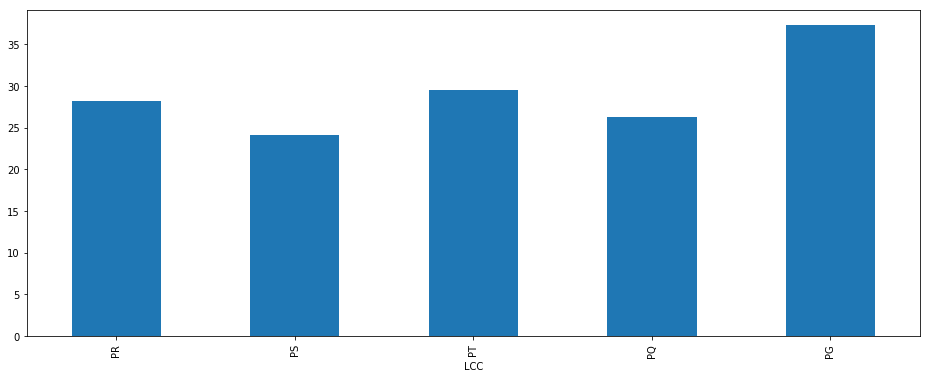

In [176]:
df.groupby(df['LCC'])['numChapters'].mean()[['PR', 'PS', 'PT', 'PQ', 'PG']].plot(kind='bar')

But maybe this is slightly skewed, because there are more `PR` books than `PG`? How many of them are there? 

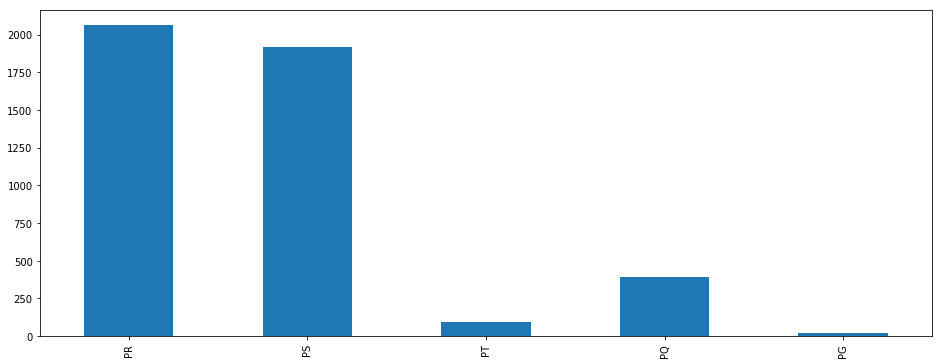

In [177]:
df['LCC'].value_counts()[['PR', 'PS', 'PT', 'PQ', 'PG']].plot(kind='bar')

# By LCSH

In [91]:
allSubj = {}
for i, row in df.iterrows(): 
    lcshRaw = row.lcsh
#     print(row.lcsh)
    try: 
        evaled = list(literal_eval(lcshRaw[0]))
    except: 
        continue
    for subj in evaled: 
        if subj in allSubj: 
            allSubj[subj].append(row['numChapters'])
        else: 
            allSubj[subj] = [row['numChapters']]

In [117]:
subjWithAtLeast5 = {k:v for k,v in allSubj.items() if len(v) > 30}

In [118]:
len(subjWithAtLeast5)

96

In [119]:
averages = {subj: np.mean(chaps) for subj, chaps in subjWithAtLeast5.items()}

In [127]:
avgChapsBySubject = {i: averages[i] for i in sorted(averages, key=averages.get, reverse=True)}

In [152]:
s = pd.Series(avgChapsBySubject)
s.sort_values(ascending=False)

English fiction -- 19th century                                  40.590909
Bildungsromans                                                   37.632911
Domestic fiction                                                 37.620690
Inheritance and succession -- Fiction                            37.440860
England -- Fiction                                               37.285714
Sisters -- Fiction                                               36.483871
Political fiction                                                35.301887
Young men -- Fiction                                             34.581395
Clergy -- Fiction                                                34.062500
Indexes                                                          33.846154
Married women -- Fiction                                         33.181818
Psychological fiction                                            33.164384
Courtship -- Fiction                                             32.558824
Didactic fiction         

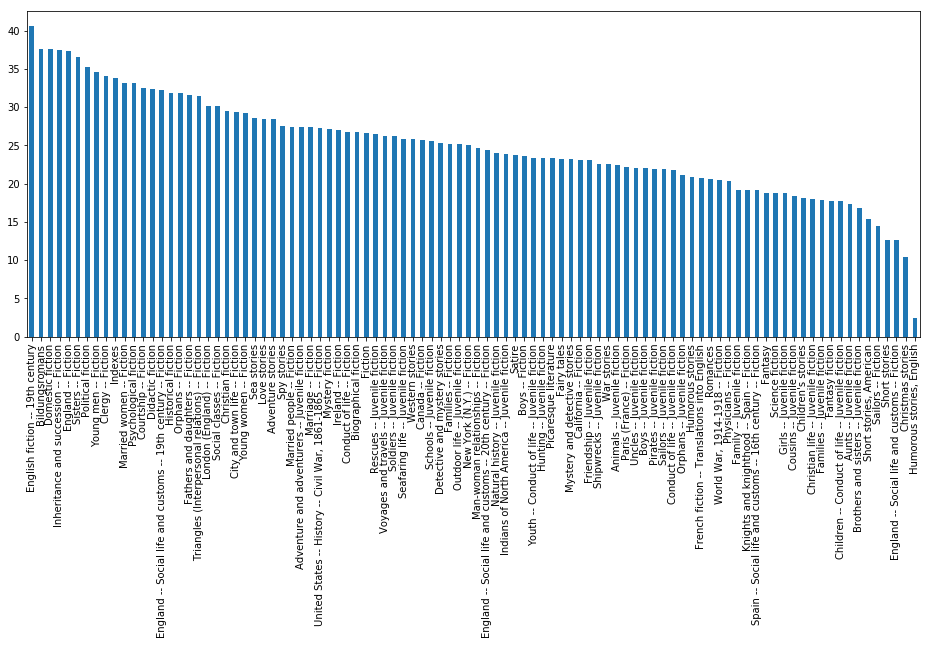

In [150]:
s.sort_values(ascending=False).plot(kind='bar')

# By Author Year of Birth

In [16]:
df.authoryearofbirth = df.authoryearofbirth.apply(lambda x: x[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b556f76d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2b5552e5c0>], dtype=object)

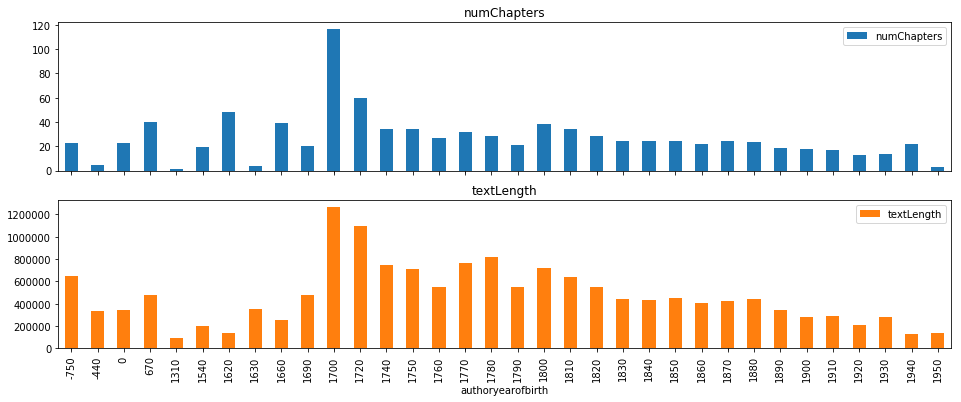

In [175]:
df.groupby(df['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)).mean().plot(kind='bar', subplots=True)

# Average Chapter Length by Author DOB

In [13]:
df['averageChapLength'] = df['chapterLengths'].apply(np.mean)

/home/jon/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d28d76390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d2821f320>], dtype=object)

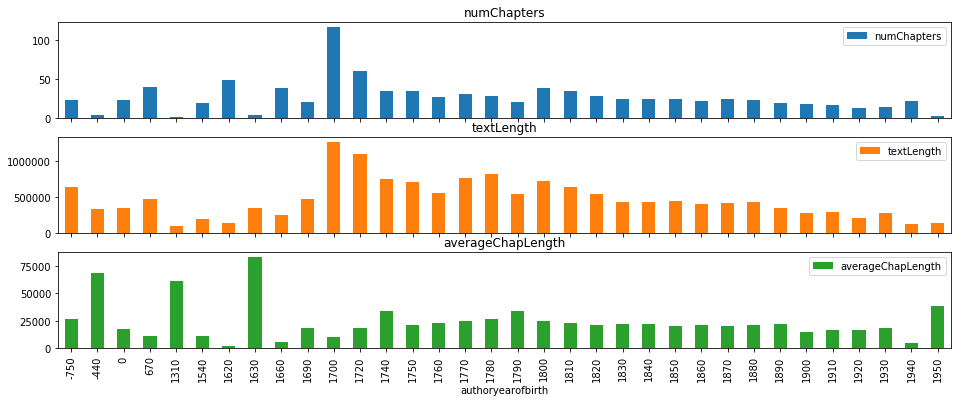

In [19]:
df.groupby(df['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)).mean().plot(kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d20841240>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d207d5630>], dtype=object)

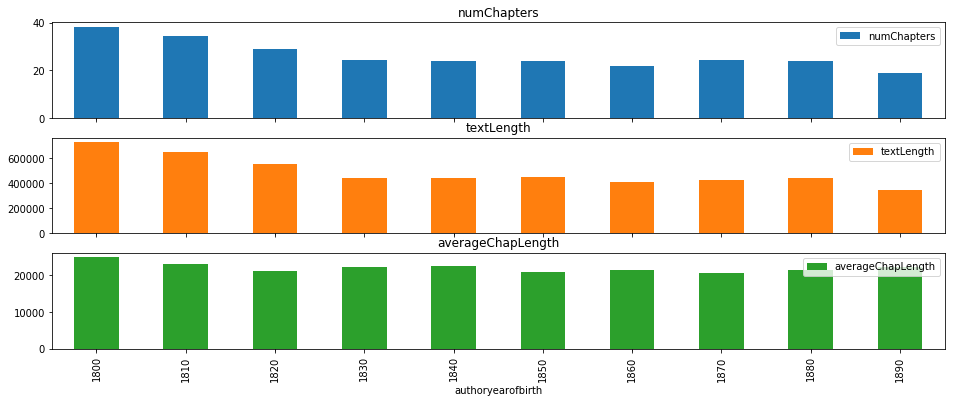

In [29]:
decs = df['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)
df.groupby(decs).mean().loc[1800:1890].plot(kind='bar', subplots=True)

# Only British Literature

In [34]:
prdf = df[df['LCC']== 'PR']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d2051fba8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d20453b00>], dtype=object)

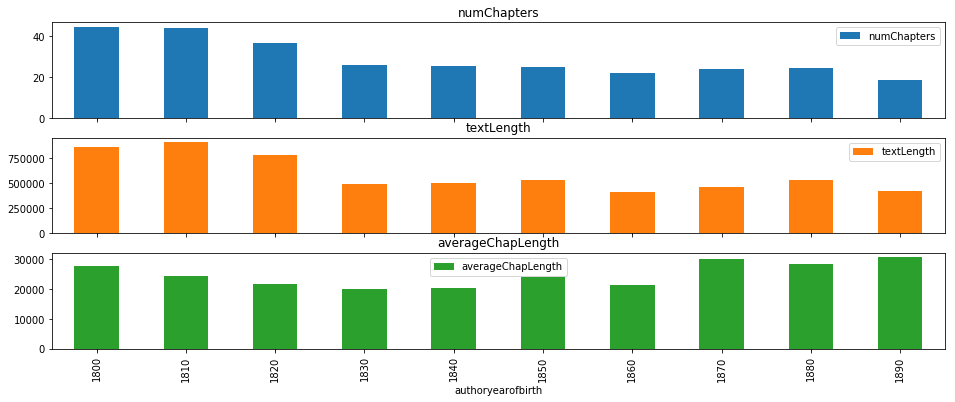

In [35]:
decs = prdf['authoryearofbirth'].apply(lambda x: (int(x)//10)*10 if len(x)>0 else 0)
prdf.groupby(decs).mean().loc[1800:1890].plot(kind='bar', subplots=True)

# British Lit by Subject

In [36]:
allSubj = {}
for i, row in prdf.iterrows(): 
    lcshRaw = row.lcsh
#     print(row.lcsh)
    try: 
        evaled = list(literal_eval(lcshRaw[0]))
    except: 
        continue
    for subj in evaled: 
        if subj in allSubj: 
            allSubj[subj].append(row['numChapters'])
        else: 
            allSubj[subj] = [row['numChapters']]

In [37]:
subjWithAtLeast5 = {k:v for k,v in allSubj.items() if len(v) > 30}

In [38]:
len(subjWithAtLeast5)

26

In [39]:
averages = {subj: np.mean(chaps) for subj, chaps in subjWithAtLeast5.items()}

In [40]:
avgChapsBySubject = {i: averages[i] for i in sorted(averages, key=averages.get, reverse=True)}

In [41]:
s = pd.Series(avgChapsBySubject)
s.sort_values(ascending=False)

Bildungsromans                                                   49.636364
Domestic fiction                                                 44.511905
English fiction -- 19th century                                  40.590909
England -- Fiction                                               38.793388
Inheritance and succession -- Fiction                            37.918033
Psychological fiction                                            37.411765
London (England) -- Fiction                                      34.446154
Indexes                                                          34.193548
Love stories                                                     33.764706
Triangles (Interpersonal relations) -- Fiction                   32.656250
Young women -- Fiction                                           31.947368
England -- Social life and customs -- 19th century -- Fiction    31.846154
Historical fiction                                               31.724138
Adventure stories        

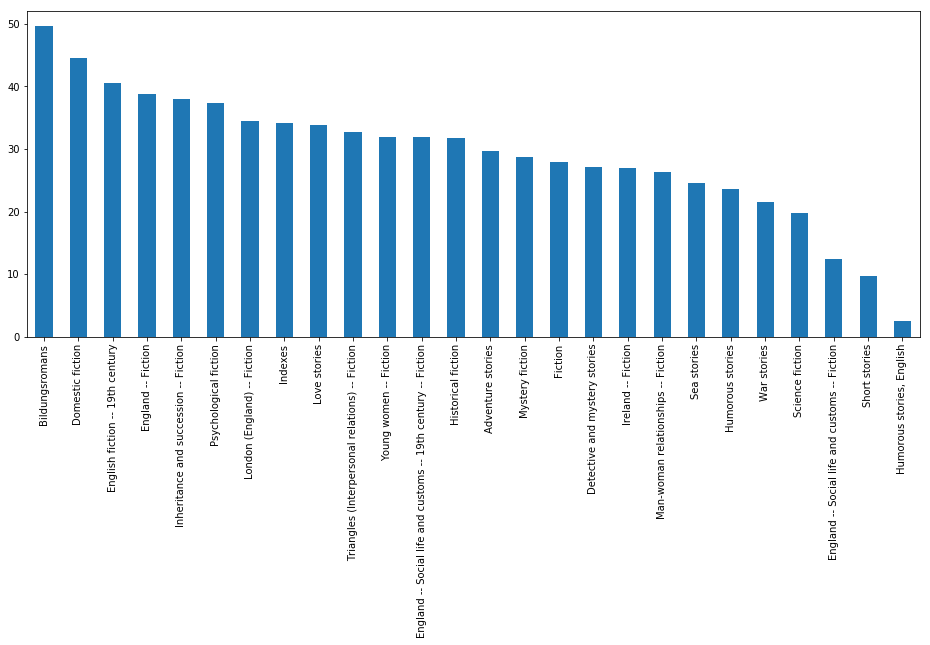

In [42]:
s.sort_values(ascending=False).plot(kind='bar')